In [2]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated2.csv')

data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)

data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
data['pct_caucasian'] = data['ETH1_EUR'] / data['POPULATION']
data['pct_africanamerican'] = data['ETH1_AA'] / data['POPULATION']
data['pct_other'] = data['ETH1_OTHERS'] / data['POPULATION']

data['Biden Percentage'] = data['Biden Percentage'] / 100
data['Trump Percentage'] = data['Trump Percentage'] / 100
data['Others Percentage'] = 1 - data['Biden Percentage'] - data['Trump Percentage']

data = data.dropna()
rows_with_negative_eth_other = data[data['ETH1_OTHERS'] < 0]
data = data.drop(rows_with_negative_eth_other.index)
data.head()
print(data)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected ! Aesara will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


     OBJECTID  DISTRICT  POPULATION   RDED  TOTAL_REG  ETH1_EUR  ETH1_AA  \
0           1         1        1602  01-01       1254       211      936   
1           2         1        1982  01-02       1579       155     1310   
2           3         1        1692  01-03       1262        83     1094   
3           4         1        2067  01-04       1619       249     1224   
4           5         1        2063  01-05       1636       589      826   
..        ...       ...         ...    ...        ...       ...      ...   
508       520        41        2101  41-04       1622      1307       92   
509       521        41        3398  41-05       2001      1402      281   
510       522        41        2863  41-06       2367      2015       40   
511       523        41        2532  41-07       1619      1210      126   
512       524        41        2817  41-08       2601      1972      119   

     Biden Percentage  Trump Percentage  ETH1_OTHERS  pct_caucasian  \
0              0

C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\numba\core\decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
C:\Users\danda\AppData\Local\Temp\ipykernel_21852\3540093178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_21852\3540093178.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Hawkins Percentage','Jorgensen Percentage'], inplace=True)
C:\

In [42]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_caucasian','pct_africanamerican', 'pct_other']]).T
votes_fractions = np.array(data[['Biden Percentage', 'Trump Percentage','Others Percentage']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

negative_values = group_fractions[group_fractions < 0]
print("Negative values:", negative_values)

candidate_names_rbyc = ['Biden', 'Trump', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["POPULATION"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)


Negative values: []
Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 424


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [63]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
#np.set_printoptions(threshold=np.inf)

demographic_group_counts = np.transpose(
            ei_rbyc.demographic_group_fractions * ei_rbyc.precinct_pops
        )
#print(demographic_group_counts)



print(sampled_voting_prefs[:,0,0])

[[[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.57410238 0.24387867]]

 [[0.12754107 0.57975634 0.29270259]
  [0.39261561 0.40197026 0.20541413]
  [0.18201895 0.574102

array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

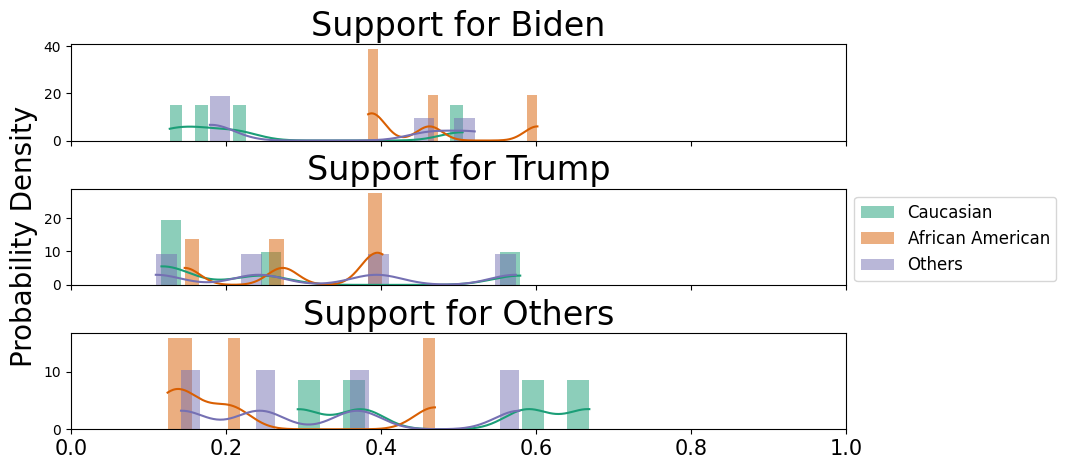

In [44]:
ei_rbyc.plot()

In [64]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist()  # Converting numpy array to Python list
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [4]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('DE_precincts_updated3.csv')
data = df.dropna()
data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
data['pct_caucasian'] = data['ETH1_EUR'] / data['POPULATION']
data['pct_africanamerican'] = data['ETH1_AA'] / data['POPULATION']
data['pct_other'] = data['ETH1_OTHERS'] / data['POPULATION']

data['Rochester Percentage'] = data['Rochester Percentage'] / 100
data['Murphy Percentage'] = data['Murphy Percentage'] / 100
data['Others Percentage'] = 1 - data['Rochester Percentage'] - data['Murphy Percentage']

data = data.dropna()
rows_with_negative_eth_other = data[data['ETH1_OTHERS'] < 0]
data = data.drop(rows_with_negative_eth_other.index)
data.head()

C:\Users\danda\AppData\Local\Temp\ipykernel_22456\3176071873.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=['Shape__Are','Shape__Len','ETH1_UNK'], inplace=True)
C:\Users\danda\AppData\Local\Temp\ipykernel_22456\3176071873.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ETH1_OTHERS'] = data['POPULATION'] - data['ETH1_EUR'] - data['ETH1_AA']
C:\Users\danda\AppData\Local\Temp\ipykernel_22456\3176071873.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

OBJECTID  DISTRICT  POPULATION   RDED  TOTAL_REG  ETH1_EUR  ETH1_AA  \
0         1         1        1602  01-01       1254       211      936   
1         2         1        1982  01-02       1579       155     1310   
2         3         1        1692  01-03       1262        83     1094   
3         4         1        2067  01-04       1619       249     1224   
4         5         1        2063  01-05       1636       589      826   

   Rochester Percentage  Murphy Percentage  ETH1_OTHERS  pct_caucasian  \
0                0.9226             0.0696          455       0.131710   
1                0.9452             0.0482          517       0.078204   
2                0.9567             0.0341          515       0.049054   
3                0.9301             0.0551          594       0.120464   
4                0.8652             0.1191          648       0.285507   

   pct_africanamerican  pct_other  Others Percentage  
0             0.584270   0.284020             0.0078  
1             0.660949   0.260848             0.0066  
2             0.646572   0.304374             0.0092  
3             0.592163   0.287373             0.0148  
4             0.400388   0.314106             0.0157

In [5]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(data[['pct_caucasian','pct_africanamerican', 'pct_other']]).T
votes_fractions = np.array(data[['Rochester Percentage', 'Murphy Percentage','Others Percentage']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

negative_values = group_fractions[group_fractions < 0]
print("Negative values:", negative_values)

candidate_names_rbyc = ['Rochester', 'Murphy', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(data["POPULATION"])
precinct_names = np.array(data['RDED'])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       precinct_names=precinct_names
)

Negative values: []
Running ['Caucasian', 'African American', 'Others'] x ['Rochester', 'Murphy', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 495


C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

There were 4000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Rochester'}>,
       <Axes: title={'center': 'Support for Murphy'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

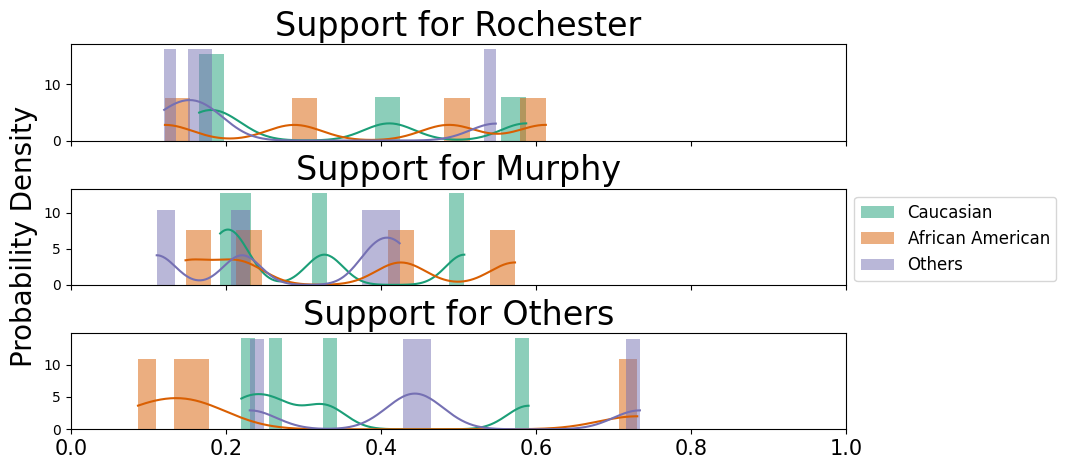

In [6]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [8]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Rochester", "Murphy", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "DELAWARE",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "RepInCongress"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [4]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('AL_ei_data.csv')

df['checksum'] = df['pct_eth1_eur'] + df['pct_eth1_aa'] + df['pct_eth1_other']

tolerance = 1e-8  # Adjust as needed

df[['pct_eth1_eur', 'pct_eth1_aa', 'pct_eth1_other']] = df[['pct_eth1_eur', 'pct_eth1_aa', 'pct_eth1_other']].round(decimals=8)
df = df[df['checksum'] == 1]
df = df[:-99300]

# Find rows where checksum is not approximately equal to 1
df.head()
print(df)

      Unnamed: 0  total_reg  party_rep  party_dem  eth1_eur  eth1_aa  \
0              0        454        382         42       416        5   
9              9        450        342         82       362       61   
10            10        172         84         73        96       60   
11            11        358        287         43       305       26   
12            12        523        246        245       265      229   
...          ...        ...        ...        ...       ...      ...   
3990        3990          6          0          6         0        6   
3999        3999          8          5          2         6        0   
4000        4000         75         42          9        62        0   
4012        4012          1          0          0         1        0   
4014        4014         25         19          1        24        0   

      party_other  eth1_other  pct_party_rep  pct_party_dem  pct_party_other  \
0              30          33       0.841410       0.09

In [2]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(df[['pct_eth1_eur','pct_eth1_aa', 'pct_eth1_other']]).T
votes_fractions = np.array(df[['pct_party_dem', 'pct_party_rep','pct_party_other']]).T

group_fractions = np.round(group_fractions, decimals=6)
votes_fractions = np.round(votes_fractions, decimals=6)

not1values = group_fractions[group_fractions != 1]
not1values2 = votes_fractions[votes_fractions != 1]
print("non1 values:", not1values)
print("non1 VALUES:", not1values2)

candidate_names_rbyc = ['Biden', 'Trump', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']

precinct_pops = np.array(df["total_reg"])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names
)


non1 values: [0.9163   0.804444 0.55814  ... 0.173333 0.       0.04    ]
non1 VALUES: [0.092511 0.182222 0.424419 ... 0.125    0.32     0.2     ]
Running ['Caucasian', 'African American', 'Others'] x ['Biden', 'Trump', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 2092


C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Biden'}>,
       <Axes: title={'center': 'Support for Trump'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

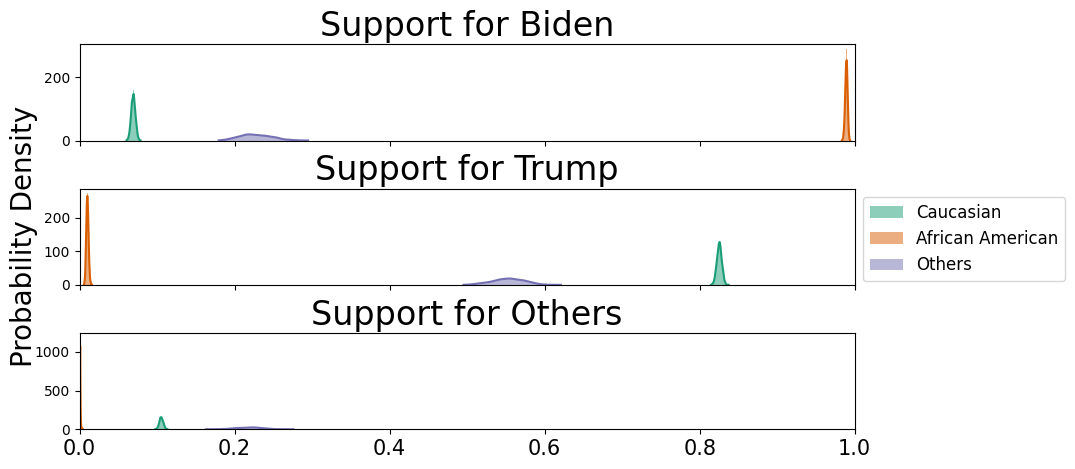

In [3]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [4]:
print(sampled_voting_prefs)

[[[6.91675530e-02 8.27416135e-01 1.03416312e-01]
  [9.87714567e-01 1.03337962e-02 1.95163716e-03]
  [2.17627066e-01 5.55702685e-01 2.26670249e-01]]

 [[7.18313805e-02 8.25306767e-01 1.02861852e-01]
  [9.87570528e-01 1.14830926e-02 9.46379679e-04]
  [2.13639391e-01 5.65594194e-01 2.20766415e-01]]

 [[6.63457682e-02 8.29346257e-01 1.04307974e-01]
  [9.89703154e-01 8.91462489e-03 1.38222107e-03]
  [2.14826889e-01 5.53984787e-01 2.31188324e-01]]

 ...

 [[7.71694791e-02 8.21151154e-01 1.01679367e-01]
  [9.88659074e-01 1.07619641e-02 5.78962156e-04]
  [2.02125333e-01 5.62402556e-01 2.35472111e-01]]

 [[7.24110304e-02 8.22479069e-01 1.05109901e-01]
  [9.89358203e-01 9.93482350e-03 7.06973919e-04]
  [1.95598275e-01 5.69586001e-01 2.34815724e-01]]

 [[7.25693214e-02 8.25956079e-01 1.01474600e-01]
  [9.89523313e-01 9.93052258e-03 5.46164645e-04]
  [1.97222839e-01 5.65584570e-01 2.37192591e-01]]]


In [5]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Biden", "Trump", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "ALABAMA",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "Presidential"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [5]:
import numpy as np
import pymc as pm

from pyei.two_by_two import TwoByTwoEI
from pyei.goodmans_er import GoodmansER
from pyei.goodmans_er import GoodmansERBayes
from pyei.r_by_c import RowByColumnEI
from pyei.io_utils import from_netcdf, to_netcdf
import pandas as pd

df = pd.read_csv('AL_countydata.csv')
print(df)

    voted_for_flowers  voted_for_ivey  votecount  voted_eur  voted_aa  \
0                3515           13387      17744      13547      2865   
1               10296           58823      73187      62056      3215   
2                2549            3888       6548       3759      2433   
3                 930            4681       5884       4765       786   
4                 930           14895      16605      15252       180   
..                ...             ...        ...        ...       ...   
61              17937           31841      51599      34855     13394   
62               1905           15217      17836      15489       901   
63               1206            4584       5929       4260      1159   
64               2489            1371       3903       1048      2684   
65                344            6331       6928       6464        22   

    voted_for_others  voted_oth  pct_flowers  pct_ivey  pct_others  \
0                842       1332     0.198095  0.75445

In [7]:
ei_rbyc = RowByColumnEI(model_name='multinomial-dirichlet-modified', pareto_shape=100, pareto_scale=100)

group_fractions = np.array(df[['pct_eth_eur','pct_eth_aa', 'pct_eth_oth']]).T
votes_fractions = np.array(df[['pct_flowers', 'pct_ivey','pct_others']]).T


candidate_names_rbyc = ['Flowers', 'Ivey', 'Others']
demographic_group_names_rbyc = ['Caucasian','African American', 'Others']


precinct_pops = np.array(df["votecount"])

ei_rbyc.fit(group_fractions, 
       votes_fractions, 
       precinct_pops, 
       demographic_group_names=demographic_group_names_rbyc, 
       candidate_names=candidate_names_rbyc, 
       #precinct_names=precinct_names
)

Running ['Caucasian', 'African American', 'Others'] x ['Flowers', 'Ivey', 'Others'] EI
r = 3 rows (demographic groups)
c = 3 columns (candidates or voting outcomes)
number of precincts = 66


C:\Users\danda\PhpstormProjects\cse416-rockets\python_stuff\venv\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: title={'center': 'Support for Flowers'}>,
       <Axes: title={'center': 'Support for Ivey'}, ylabel='Probability Density'>,
       <Axes: title={'center': 'Support for Others'}>], dtype=object)

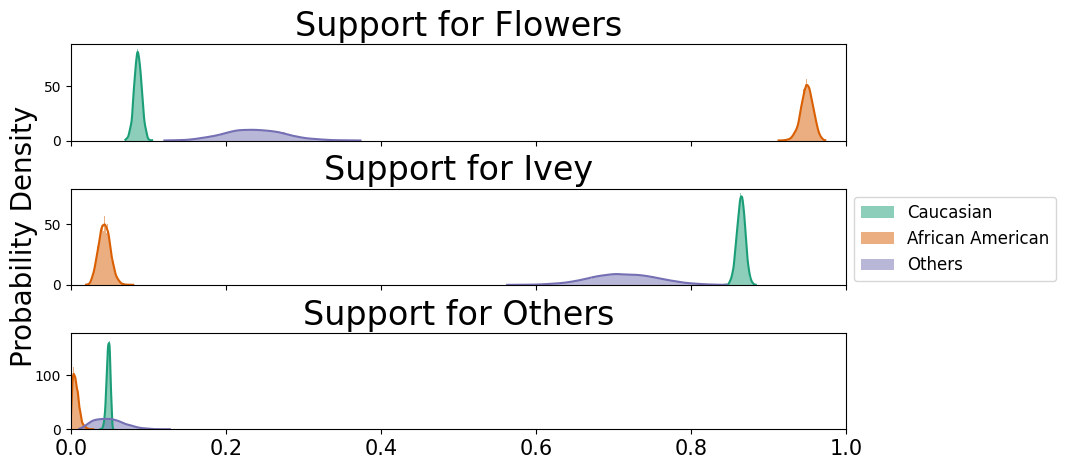

In [8]:
sampled_voting_prefs = ei_rbyc.sampled_voting_prefs
ei_rbyc.plot()

In [9]:
print(sampled_voting_prefs)

[[[8.56656865e-02 8.62479460e-01 5.18548536e-02]
  [9.50328754e-01 4.78058549e-02 1.86539116e-03]
  [2.49748698e-01 7.13273298e-01 3.69780044e-02]]

 [[9.09754562e-02 8.57734618e-01 5.12899256e-02]
  [9.47614788e-01 5.00678958e-02 2.31731570e-03]
  [1.98638432e-01 7.59647628e-01 4.17139404e-02]]

 [[9.16106686e-02 8.59304489e-01 4.90848429e-02]
  [9.41825601e-01 5.50315951e-02 3.14280376e-03]
  [2.13937463e-01 7.35441882e-01 5.06206545e-02]]

 ...

 [[8.71938360e-02 8.64478923e-01 4.83272406e-02]
  [9.55555288e-01 4.19951214e-02 2.44959079e-03]
  [2.12445837e-01 7.22914425e-01 6.46397372e-02]]

 [[8.12183847e-02 8.71223713e-01 4.75579027e-02]
  [9.47924861e-01 5.12464145e-02 8.28724036e-04]
  [2.89526654e-01 6.41140652e-01 6.93326941e-02]]

 [[8.52587918e-02 8.63640109e-01 5.11010996e-02]
  [9.53421954e-01 4.60436166e-02 5.34429677e-04]
  [2.48472762e-01 7.08254797e-01 4.32724412e-02]]]


In [26]:
import pymongo
import json
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["cse416-rockets"]
collection = db["ecoInfData"]
arr = sampled_voting_prefs

candidates = ["Flowers", "Ivey", "Others"]
groups = ["caucasian", "african american", "Other"]

for candidate_idx, candidate in enumerate(candidates):
    for group_idx, group in enumerate(groups):
        # Extracting data for the current candidate and demographic group
        data = arr[:, group_idx, candidate_idx]
        
        # Creating JSON document
        document = {
            "state": "ALABAMA",
            "candidate": candidate,
            "race": group,
            "data": data.tolist(),  # Converting numpy array to Python list
            "election": "Governor"
        }
        
        # Inserting document into MongoDB collection
        collection.insert_one(document)


In [3]:
import geopandas as gpd
de_prec = gpd.read_file('DE_precincts.geojson')
de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
    "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
    "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
    "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
})
ideal_pop = np.sum(de_districts['POPULATION'])/ 41
print(int(ideal_pop))

total_pop = np.sum(de_districts['POPULATION'])
print(int(total_pop))

minority_pop_aa = np.sum(de_districts['ETH1_AA'])
minority_pop_eur = np.sum(de_districts['ETH1_EUR'])

max_opp_districts_aa = minority_pop_aa / (.5 * ideal_pop)

max_opp_districts_eur = minority_pop_eur / (.5 * ideal_pop)

print(int(max_opp_districts_aa))
print(int(max_opp_districts_eur))

print("aa ",minority_pop_aa)
print("eur",minority_pop_eur)

24145
989948
11
36
aa  143365
eur 445626


In [4]:
import geopandas as gpd
de_prec = gpd.read_file('AL_precincts.geojson')
de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
    "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
    "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
    "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
})
ideal_pop = np.sum(de_districts['POPULATION'])/ 41
print(int(ideal_pop))

total_pop = np.sum(de_districts['POPULATION'])
print(int(total_pop))

minority_pop_aa = np.sum(de_districts['ETH1_AA'])
minority_pop_eur = np.sum(de_districts['ETH1_EUR'])

max_opp_districts_aa = minority_pop_aa / (.5 * ideal_pop)

max_opp_districts_eur = minority_pop_eur / (.5 * ideal_pop)

print(int(max_opp_districts_aa))
print(int(max_opp_districts_eur))

print("aa ",minority_pop_aa)
print("eur",minority_pop_eur)

122543
5024279
15
35
aa  926476.0
eur 2197450.0


In [4]:
# SOURCED FROM: https://github.com/jeffreyshen19/Seats-Votes-Curves/blob/master/generator/uniform_partisan_swing.py
# MODIFIED FOR MINORITY GROUP INSTEAD OF POLITICAL

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import random

# Now you can import GeoPandas
import geopandas as gpd


def vote_seat_shares(districts):
    votingByDistrict = []
    seatsVotesWht = []
    seatsVotesBlk = []

    SWING_CONST = 0.01  # Percentage to increase each district by

    total_votes = 0
    total_blk_votes = 0
    total_wht_votes = 0

    # Read all district data
    blk = np.sum(districts['ETH1_AA'])
    wht = np.sum(districts['ETH1_EUR'])
    total = wht + blk

    total_votes += total
    total_blk_votes += blk
    total_wht_votes += wht
    percentWht = float(wht) / total

    votingByDistrict.append({"percentWht": percentWht, "percentBlk": 1.0 - percentWht})

    WhtVoteShare = float(total_wht_votes) / total_votes
    BlkVoteShare = float(total_blk_votes) / total_votes

    diff = (((100 * WhtVoteShare) % 1) - ((100 * BlkVoteShare) % 1)) / 100  #

    # Generate curve
    i = WhtVoteShare
    counter = 0
    while i <= 1:
        totalWhtSeats = 0
        totalBlkSeats = 0
        for j in range(0, 1000):  # simulate 1000 elections

            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsWht[k] = district["percentWht"] + counter * SWING_CONST + SWING_CONST * random.randint(-5, 5)
                updatedValsBlk[k] = 1 - updatedValsWht[k] + diff

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] += SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] -= SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesWht.append({"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), "votes": i})
            seatsVotesBlk.insert(0, {"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0),
                                     "votes": 1 - i + diff})

    i = BlkVoteShare
    counter = 0

    while i <= 1:
        totalBlkSeats = 0
        totalWhtSeats = 0

        for j in range(0, 1000):  # simulate 1000 elections
            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsBlk[k] = district["percentBlk"] + counter * SWING_CONST + SWING_CONST * random.randint(-5,
                                                                                                                  5) + diff
                updatedValsWht[k] = 1 - (updatedValsBlk[k] - diff)

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] -= SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] += SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesBlk.append({"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0), "votes": i + diff})
            seatsVotesWht.insert(0, {"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), "votes": 1 - i})

    # Add endpoints
    seatsVotesWht.insert(0, {"seats": 0, "votes": 0})
    seatsVotesBlk.insert(0, {"seats": 0, "votes": 0})
    seatsVotesWht.append({"seats": 1, "votes": 1})
    seatsVotesBlk.append({"seats": 1, "votes": 1})
    
    return seatsVotesWht, seatsVotesBlk
    
if __name__ == '__main__':
    de_prec = gpd.read_file('DE_precincts.geojson')
    de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
    de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
        "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
        "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
        "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
    })

    de_wht_arr, de_blk_arr = vote_seat_shares(de_districts)

    # Plotting
    votes_blk = [entry['votes'] for entry in de_blk_arr]

    # Extracting just the 'seats'
    seats_blk = [entry['seats'] for entry in de_blk_arr]

    votes_wht = [entry['votes'] for entry in de_wht_arr]

    # Extracting just the 'seats'
    seats_wht = [entry['seats'] for entry in de_wht_arr]
    
    plt.plot(votes_blk, seats_blk, color='blue', label='Black')
    plt.plot(votes_wht, seats_wht, color='red', label='White')

    # Adding labels and title
    plt.xlabel('Vote Share')
    plt.ylabel('Seat Share')
    plt.title('Vote Seat Share')
    plt.legend()

    plt.ylim(0, 1)

    # Displaying the plot
    plt.show()


In [1]:
# SOURCED FROM: https://github.com/jeffreyshen19/Seats-Votes-Curves/blob/master/generator/uniform_partisan_swing.py
# MODIFIED FOR MINORITY GROUP INSTEAD OF POLITICAL

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import random

# Now you can import GeoPandas
import geopandas as gpd


def vote_seat_shares(districts):
    votingByDistrict = []
    seatsVotesWht = []
    seatsVotesBlk = []

    SWING_CONST = 0.001  # Percentage to increase each district by

    total_votes = 0
    total_blk_votes = 0
    total_wht_votes = 0

    # Read all district data
    blk = np.sum(districts['ETH1_AA'])
    wht = np.sum(districts['ETH1_EUR'])
    total = wht + blk

    total_votes += total
    total_blk_votes += blk
    total_wht_votes += wht
    percentWht = float(wht) / total
    percentBlk = float(blk) / total

    votingByDistrict.append({"percentWht": percentWht, "percentBlk": percentBlk})

    WhtVoteShare = float(total_wht_votes) / total_votes
    BlkVoteShare = float(total_blk_votes) / total_votes

    diff = (((100 * WhtVoteShare) % 1) - ((100 * BlkVoteShare) % 1)) / 100  #

    # Generate curve
    i = WhtVoteShare
    counter = 0
    while i <= 1:
        totalWhtSeats = 0
        totalBlkSeats = 0
        for j in range(0, 1000):  # simulate 1000 elections

            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsWht[k] = district["percentWht"] + counter * SWING_CONST + \
                                    SWING_CONST * random.randint(-5, 5)
                updatedValsBlk[k] = 1 - updatedValsWht[k] + diff

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] += SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] -= SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesWht.append({"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), "votes": i})
            seatsVotesBlk.insert(0, {"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0),
                                     "votes": 1 - i + diff})

    i = BlkVoteShare
    counter = 0

    while i <= 1:
        totalBlkSeats = 0
        totalWhtSeats = 0

        for j in range(0, 1000):  # simulate 1000 elections
            districtOverflowedWht = [False] * len(votingByDistrict);
            districtOverflowedBlk = [False] * len(votingByDistrict);
            excessBlk = 0
            excessWht = 0
            updatedValsWht = [0] * len(votingByDistrict);
            updatedValsBlk = [0] * len(votingByDistrict);

            for k, district in enumerate(votingByDistrict):
                updatedValsBlk[k] = district["percentBlk"] + counter * SWING_CONST + \
                                    SWING_CONST * random.randint(-5,5) + diff
                updatedValsWht[k] = 1 - (updatedValsBlk[k] - diff)

                if updatedValsWht[k] > 1:
                    excessWht += 1
                    districtOverflowedWht[k] = True

                if updatedValsBlk[k] < 0:
                    excessBlk += 1
                    districtOverflowedBlk[k] = True

            for k, district in enumerate(votingByDistrict):
                # Overflow mechanic: distribute excess votes to the other districts
                if districtOverflowedWht[k] is False:
                    updatedValsWht[k] -= SWING_CONST * (excessWht / (len(votingByDistrict) - excessWht))

                if districtOverflowedBlk[k] is False:
                    updatedValsBlk[k] += SWING_CONST * (excessBlk / (len(votingByDistrict) - excessBlk))

                if updatedValsWht[k] > 0.50:
                    totalWhtSeats += 1
                if updatedValsBlk[k] > 0.50:
                    totalBlkSeats += 1

        i += SWING_CONST
        counter += 1

        if i <= 1:
            seatsVotesBlk.append({"seats": float(totalBlkSeats) / (len(votingByDistrict) * 1000.0), 
                                  "votes": i + diff})
            seatsVotesWht.insert(0, {"seats": float(totalWhtSeats) / (len(votingByDistrict) * 1000.0), 
                                     "votes": 1 - i})

    # Add endpoints
    seatsVotesWht.insert(0, {"seats": 0, "votes": 0})
    seatsVotesBlk.insert(0, {"seats": 0, "votes": 0})
    seatsVotesWht.append({"seats": 1, "votes": 1})
    seatsVotesBlk.append({"seats": 1, "votes": 1})

    return seatsVotesWht, seatsVotesBlk


if __name__ == '__main__':
    de_prec = gpd.read_file('DE_precincts.geojson')
    de_prec = de_prec[de_prec['TOTAL_REG'] != 0]
    de_districts = de_prec.dissolve(by='DISTRICT', aggfunc={
        "ETH1_EUR": 'sum', "ETH1_HISP": 'sum', "ETH1_AA": 'sum', "ETH1_ESA": 'sum', "ETH1_UNK": 'sum',
        "VOTERS_GENDER_M": 'sum', "VOTERS_GENDER_F": 'sum', "VOTERS_GENDER_UNKNOWN": 'sum', "PARTY_DEM": 'sum',
        "PARTY_REP": 'sum', "PARTY_OTHER": 'sum', "POPULATION": 'sum'
    })

    de_wht_arr, de_blk_arr = vote_seat_shares(de_districts)

    # extracting data
    votes_blk = [entry['votes'] for entry in de_blk_arr]
    seats_blk = [entry['seats'] for entry in de_blk_arr]

    # extracting data
    votes_wht = [entry['votes'] for entry in de_wht_arr]
    seats_wht = [entry['seats'] for entry in de_wht_arr]

    plt.plot(votes_blk, seats_blk, color='blue', label='Black')
    plt.plot(votes_wht, seats_wht, color='red', label='White')

    # Adding labels and title
    plt.xlabel('Vote Share')
    plt.ylabel('Seat Share')
    plt.title('Vote Seat Share')
    plt.legend()

    plt.ylim(0, 1)

    # Displaying the plot
    plt.show()
